In [1]:
# IMPORTING LIBRARIES AND DEPENDENCIES

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import warnings 
warnings. filterwarnings('ignore')

%matplotlib inline

In [2]:
# GETTING DATASET
data= pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

- Make,
- Model,
- Year,
- Engine HP,
- Engine Cylinders,
- Transmission Type,
- Vehicle Style,
- highway MPG,
- city mpg
- MSRP

In [3]:
# SELECTED FEATURES 
df= data[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 
        'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg','MSRP']]

**Data preparation**

- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [5]:
# INSPECTING MISSING VALUES
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
# HANDLING MISSING VALUES
df= df.fillna(0)

In [7]:
# PROCESSING DATASET
price_mean= df['msrp'].mean()

df['above_average']= (df['msrp'] > price_mean).astype(int)

del df['msrp']

In [8]:
# INSPECTING DATAFRAME
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [9]:
# INSPECTING DATAFRAME
print(df.shape)

(11914, 10)


In [10]:
# PREPARING DATASET
num_feature=['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']
cat_feature=['make','model','transmission_type','vehicle_style']

In [11]:
# SPLITTING THE DATASET:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# PROCESSING DATASET
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# DELETING DATASET
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg

In [12]:
# CALCULATING ROC AUC SCORE:
for c in num_feature:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673


- Answer: engine_hp 0.917

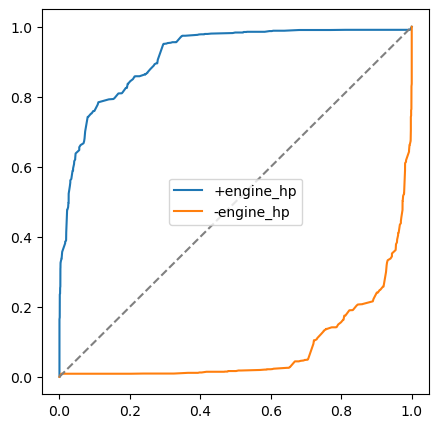

In [13]:
# PLOTTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, label='+engine_hp')

fpr, tpr, _ = roc_curve(y_train, -df_train.engine_hp)
plt.plot(fpr, tpr, label='-engine_hp')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

> LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [14]:
# TRAINING LOGISTIC REGRESSION MODEL:
columns = cat_feature + num_feature

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [15]:
#@ INSPECTING ROC AUC SCORE:
np.round(roc_auc_score(y_val, y_pred),3)

0.977

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.28
- 0.48
- 0.68
- 0.88

In [16]:
# INSPECTING THE ROC AUC SCORE:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9115082165540882

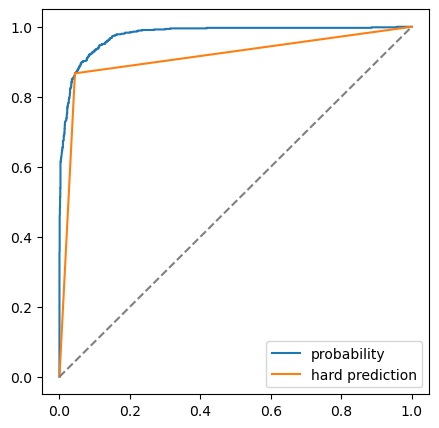

In [17]:
# INSPECTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [18]:
# CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


# IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,643,345,11,1384
20,0.2,622,218,32,1511
30,0.3,606,159,48,1570
40,0.4,588,109,66,1620
50,0.5,567,76,87,1653
60,0.6,522,49,132,1680
70,0.7,490,36,164,1693
80,0.8,440,17,214,1712
90,0.9,347,4,307,1725


In [19]:
# ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

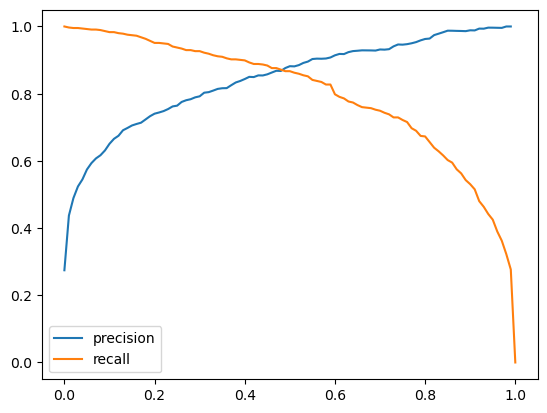

In [20]:
# INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

- Answer: ~= 0.48

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [21]:
# GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

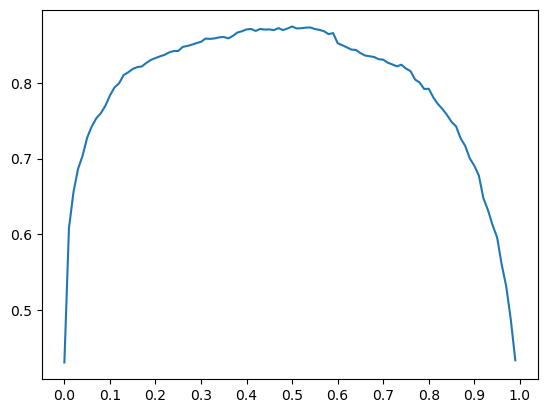

In [22]:
# INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

- Answer: ~= 0.52

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

> KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [23]:
# DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
# INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.981 +- 0.003


- Answer: 0.003

### Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [25]:
# INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.003
C= 0.1, 0.972 +- 0.001
C=   1, 0.981 +- 0.003
C=  10, 0.981 +- 0.003


- Answer: 0.1